Uncomment the lines below to disable GPU acceleration. Depending on your setup, this might speed up execution.

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ex5 import Pendulum, rbfprojector, Model, Memory
from time import time
from tqdm import tqdm
help(Model)

Help on class Model in module ex5:

class Model(Network)
 |  Deep learning-based dynamics model approximator.
 |  
 |  METHODS
 |      train       -- Train network on minibatch.
 |      fit         -- Fit network on memory.
 |      __call__    -- Evaluate network.
 |  
 |  Method resolution order:
 |      Model
 |      Network
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, s, a)
 |      Evaluates the dynamics approximator.
 |      
 |      r, sp = Model(s, a) returns the approximated reward `r` and next
 |      state `sp` at observation `s` and action `a`.
 |      
 |      `s` is either a vector specifying a single observation, or a
 |      matrix in which each row specifies one observation in a batch.
 |      `a` is the same size as the number of rows in `s`, and specifies
 |      the action at which to evaluate each observation in the batch.
 |      
 |      EXAMPLE
 |          >>> model = Model(2, 1, [10, 10])
 |          >>> print(model([0, 0], 0))
 

## 1 Exercise

### Exercise 1.1.

The Model class has a hidden parameter `diff`. Read `ex5.py` and try to figure out what it does. Why could this be advantageous?

#### Answer: 

Such parameter allows to train the model using as inputs the current state and action, and as output the transition and reward. There is an advantage of getting this "delta" value of state. Since the value of the transition is smaller the noise reflected from the model to the $s^{'}$ would be smaller because a big contribution will come from the actual state. This will also reduce the possible range of values the model will have to deal, since the range of possible values for transitions are considerable smaller than the range of possible values for states.

## 2 Exercise

### Exercise 2.1.

Adapt the State-Value Actor Critic algorithm from Exercise 4 to keep track of all experienced transitions (use `Memory`), and use these at the end of every episode to train a neural network on the system dynamics (use `Model.fit`).

#### Answer: 

The implementation is contained in the cells bellow.

In [2]:
def initialize_weights_svac(shape):
    #Function to initiliaze weights w and theta of SVAC
    w = np.zeros(shape)
    theta = np.random.rand(shape)
    return w, theta

In [3]:
def compute_action(s, theta, feature, sigma):
    #Function to compute the action of the model based in a certain distribution
    phi_s = feature(s)
    pi_s_theta = np.dot(theta, phi_s)
    a = np.random.normal(pi_s_theta, scale=sigma, size=None)
    return a, phi_s, pi_s_theta

In [4]:
def update_weights_svac(w, theta, feature, phi_s, sP, a, r, pi_s_theta, alpha, beta, gamma):
    #Function to update the weights based in the feature and information from: (s, sP, a, r)
    phi_sP = feature(sP)
    delta = r + gamma*np.dot(w, phi_sP) - np.dot(w, phi_s)
    w = w + alpha*delta*phi_s
    theta = theta + beta*(a-pi_s_theta)*phi_s*delta        
    return w, theta

In [5]:
def condition_states(states, env):
    #Function to verify if states are contained in the limits of the environment
    low = env.env.observation_space.low
    high = env.env.observation_space.high
    return [not(low[k] <= states[k] <= high[k]) for k in range(states.shape[0])]

In [6]:
def condition_error(error_r, error_sP, tol):
    #Function to verify if the error for the states and the reward are in an aceptable interval (<error_tol)
    condition_sP = all([error < tol for error in error_sP])
    condition_r = error_r < tol
    return condition_sP and condition_r

In [7]:
def state_value_action_critic(env, 
                              sigma=1, 
                              gamma=0.99, 
                              alpha=0.2, 
                              beta=0.01, 
                              episodes=100, 
                              steps=1000, 
                              render_step=0, 
                              rate=0.99,
                              N=10,
                              project_basis=21,
                              std_projector=0.25,
                              error_tol=0.1,
                              pred_time_steps=20,
                              n_states=3,
                              plot=True
                             ):
    # Initialize reward and error vectors
    rewards, rmses_r, rmses_sP = np.zeros((episodes, 1)), np.zeros((episodes, 1)), np.zeros((episodes, n_states))
    # Create feature as a rbfprojector
    feature = rbfprojector(project_basis, std_projector)
    # Initialize w and theta
    w, theta = initialize_weights_svac(len(feature(n_states*[0])))
    # Create model and memory
    memory = Memory(n_states, 1)
    model =  Model(n_states)
    start = time()
    for e in range(episodes):
        s = env.reset()
        total_r, errors_r, errors_sP = 0, np.zeros((steps,1)), np.zeros((steps, n_states))
        for t in range(steps):
            # Compute action, phi_s and policy, then apply action to environment
            a, phi_s, pi_s_theta = compute_action(s, theta, feature, sigma)
            sP, r, done, _ = env.step(a)
            # Add information of state, state prime, action, reward and terminal tag to memory
            memory.add(s, a, r, sP, done)
            # Apply state and action to model to verify the error
            pred_r, pred_sP = model(s, a)
            errors_r[t] = r - pred_r
            errors_sP[t,:] = sP - pred_sP
            total_r+=r
            # Update weights of the SVAC
            w, theta = update_weights_svac(w, 
                                           theta, 
                                           feature,
                                           phi_s, 
                                           sP, 
                                           a, 
                                           r, 
                                           pi_s_theta, 
                                           alpha, 
                                           beta, 
                                           gamma)
            # If possible not null render_step, render simulation
            if render_step and not t%render_step:
                env.render()
            if done:
                break
            s = sP
        rmses_r[e] = np.sqrt(np.power(errors_r, 2).mean())
        rmses_sP[e, :] = np.sqrt(np.power(errors_sP, 2).mean(axis=0))
        # Check if model error is low enough to enter the simulation enviroment step
        if condition_error(rmses_r[e], rmses_sP[e,:], error_tol):
            for n in range(N):
                s = env.reset()
                for i in range(pred_time_steps):
                    # Compute action and policy
                    a, phi_s, pi_s_theta = compute_action(s, theta, feature, sigma)
                    # Predict reward and sP, normalize sP and if the state condition is attended, update weights
                    pred_r, pred_sP = model(s, a)
                    pred_sP = env.normalize(pred_sP)
                    if any(condition_states(pred_sP, env)):
                        break
                    w, theta = update_weights_svac(w, 
                                                   theta, 
                                                   feature,
                                                   phi_s, 
                                                   pred_sP, 
                                                   a, 
                                                   pred_r, 
                                                   pi_s_theta, 
                                                   alpha, 
                                                   beta, 
                                                   gamma)
                    s = pred_sP
        # Fit the model with the memory information
        model.fit(memory)
        rewards[e] = total_r
        # Update sigma
        sigma = sigma*rate
    end = time()
    if plot:
        env.plotlinear(w, theta, feature)
        env.plotnetwork(model)
    env.close()
    return theta, w, np.array(rewards), end-start, rmses_sP, rmses_r

### Exercise 2.2.

After every experienced transition, estimate its reward and next state using the model, and track the the root mean squared error (RMSE) of both for each episode. Plot them to make an estimate of when the model is good enough to start using to generate simulated transitions. Also plot the model dynamics using `Pendulum.plotnetwork`, and interpret the graphs.

#### Answer:


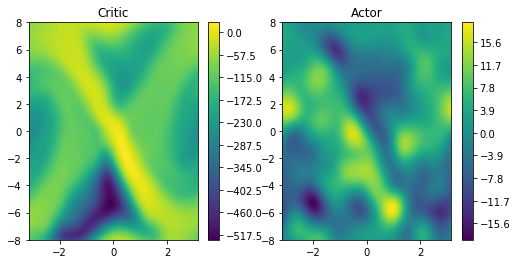

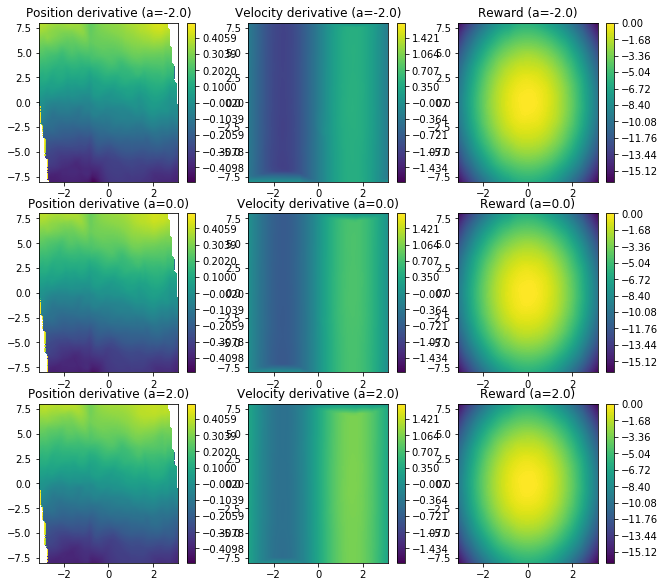

In [8]:
env = Pendulum()
theta, w, rewards, sim_time, rmses_sP, rmses_r = state_value_action_critic(env)

##### INTERPRETATION OF THE CHARTS

First, interpreting the chart about the reward. As can be seen in the documentation of the environment, the equation that computes the reward can be found, and is defined as a weighted sum between $-\theta^2$, $-\dot{\theta}^2$ and the $-torque^2$. The action has a small impact in the reward function.  The model was able to find a good estimation of the real reward function of the environment as can be seen by the graphics in the third column which contain elipses formed by contours of the same colour, which is exactly the pattern expected from a curve formed by a weight sum of $\theta^2$ and $\dot{\theta}^2$.

For the second column it's possible to see a sinusoidal variation horizontally. Checking the documentation for `gym` library, the delta thetadot depends on the action and sine of theta, since the action is constant, the result the models return is aligned with equation of the system. A similar effect happens for the first columns. Some problems and noise that appears in the chart can be a consequence of errors and uncertainty in the model. 

##### Errors and criteria

Below, the chart of the reward throughout all the episodes is shown, where the convergence of the algorithm can be checked. The RMSE for the reward and for each state is shown the following two cells. As criteria to use the model for prediction, was chosen a tolerance of 0.1, when all errors are bellow this value, the model can be applied, and simulated episodes are used.

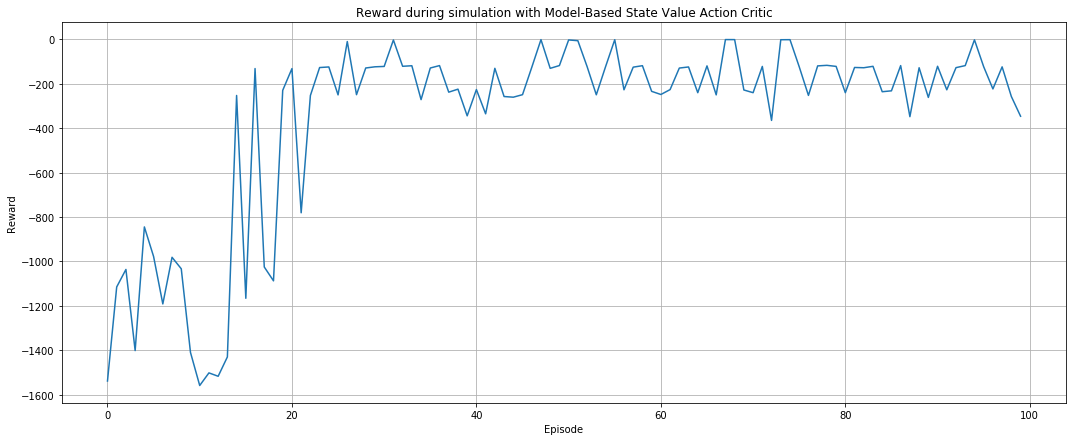

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.plot(rewards)
ax.set_title("Reward during simulation with Model-Based State Value Action Critic")
plt.xlabel("Episode")
plt.grid()
plt.ylabel("Reward")
plt.show()

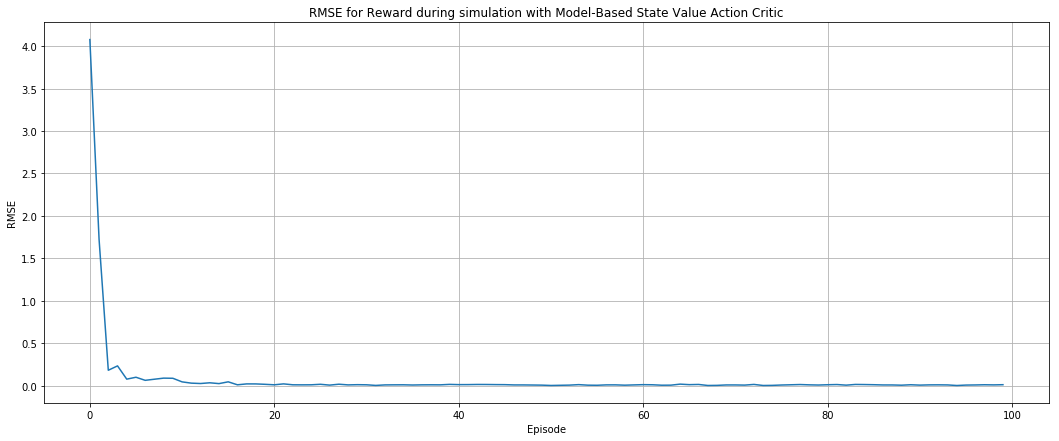

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.plot(rmses_r)
ax.set_title("RMSE for Reward during simulation with Model-Based State Value Action Critic")
plt.xlabel("Episode")
plt.grid()
plt.ylabel("RMSE")
plt.show()

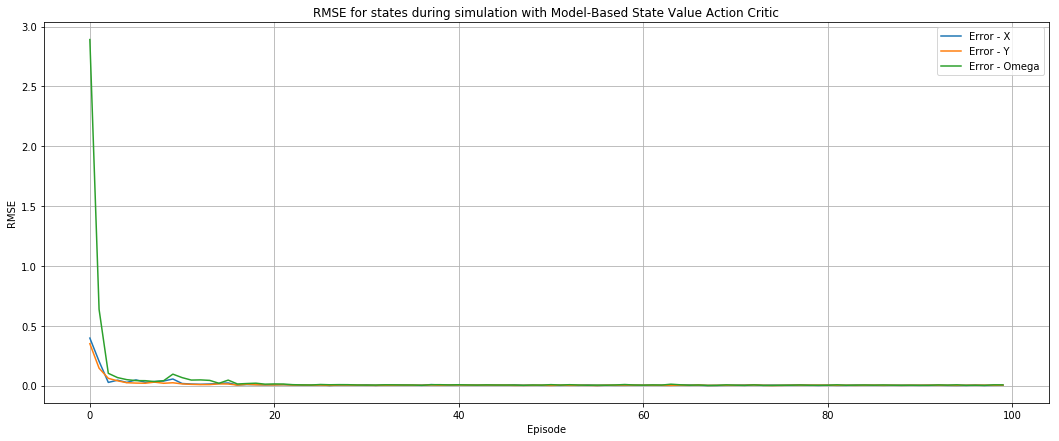

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.plot(rmses_sP)
ax.set_title("RMSE for states during simulation with Model-Based State Value Action Critic")
plt.xlabel("Episode")
plt.grid()
plt.ylabel("RMSE")
plt.legend(['Error - X', 'Error - Y', 'Error - Omega'])
plt.show()

### Exercise 2.3.

After every real episode, run N simulated episodes of 20 transitions. Start these episodes using `env.reset()`, but use the model to estimate the next state. Terminate the episode early if any of the state variables exceeds its range (`env.env.observation_space.low` - `env.env.observation_space.high`). Use the same learning rules as in the real episode.

Call `env.normalize` on the estimated next state to make sure it is on the unit circle. Start generating simulated transitions only when the model has settled (see the previous question), and only retrain the model every few real episodes if it takes too long.

#### Answer:

This is already implemented in the function `state_action_value_critic`

### Exercise 2.4.

Investigate the sample complexity vs computational complexity trade-off by varying the amount of simulated episodes per episode N. How does the rise time change with increasing N? Is the end performance affected?
Note that you may have to run each experiment a number of times to get statistically significant results.

#### Answer:

To examine the sample complexity and computational complexity I ran 10 tests for 4 different values of $N$ (10,20, 50, 75). With this, it was possible to create box-plots for rewards and time consumption, these charts are shown below.

In [36]:
episodes = 100
env = Pendulum()
dict_rewards = {}
for n_value in [10,20,50,75]:
    all_rewards, sim_times = np.zeros((10,episodes)), np.zeros((10,1))
    for i in tqdm(range(10)):
        theta, w, rewards, sim_time, rmses_sP, rmses_r = state_value_action_critic(env, plot=False, steps=1000, episodes=episodes, N=n_value)
        all_rewards[i,:] = rewards[:,0]
        sim_times[i] = sim_time
    dict_rewards[n_value] = {"rewards": all_rewards, "times": sim_times}

100%|██████████| 10/10 [2:14:10<00:00, 805.03s/it] 


In [78]:
green_diamond = dict(markerfacecolor='g', marker='D')
positions = np.arange(1, episodes+1, 1)
x_fontsize = 8

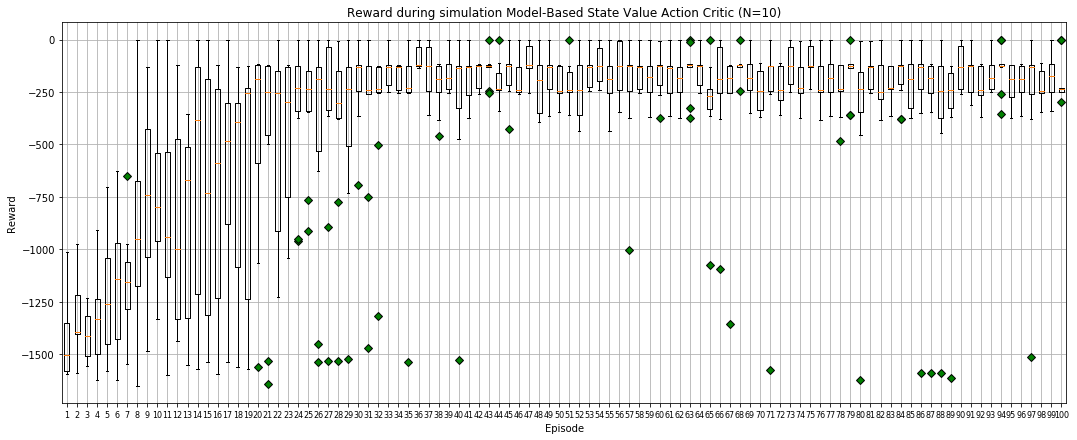

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.boxplot(dict_rewards[10]["rewards"], positions=np.arange(1,101,1), flierprops=green_diamond)
ax.set_title("Reward during simulation Model-Based State Value Action Critic (N=10)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.xticks(fontsize=x_fontsize)
plt.grid()
plt.show()

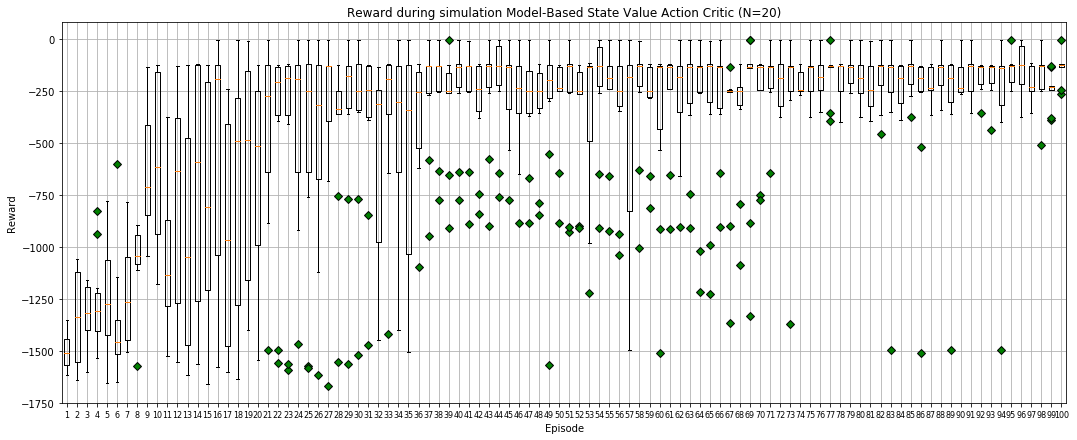

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.boxplot(dict_rewards[20]["rewards"], positions=np.arange(1,101,1), flierprops=green_diamond)
ax.set_title("Reward during simulation Model-Based State Value Action Critic (N=20)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.xticks(fontsize=x_fontsize)
plt.grid()
plt.show()

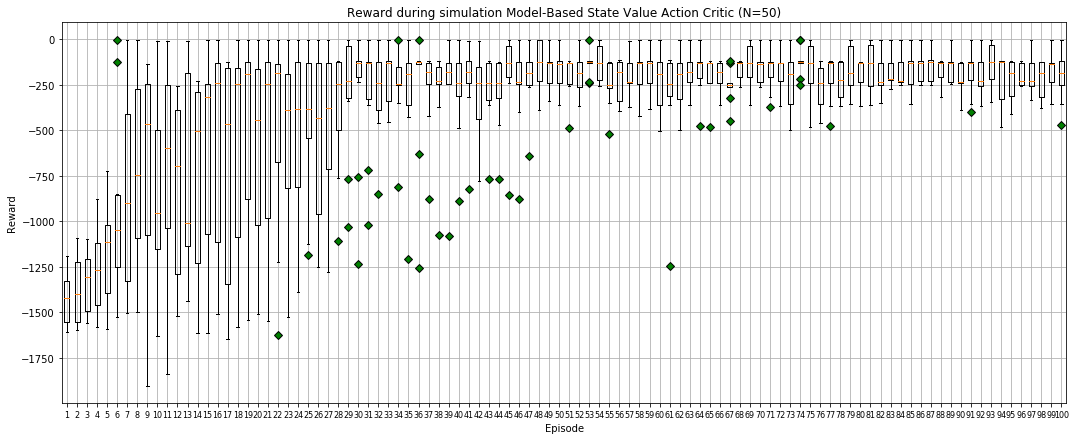

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.boxplot(dict_rewards[50]["rewards"], positions=np.arange(1,101,1), flierprops=green_diamond)
ax.set_title("Reward during simulation Model-Based State Value Action Critic (N=50)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.xticks(fontsize=x_fontsize)
plt.grid()
plt.show()

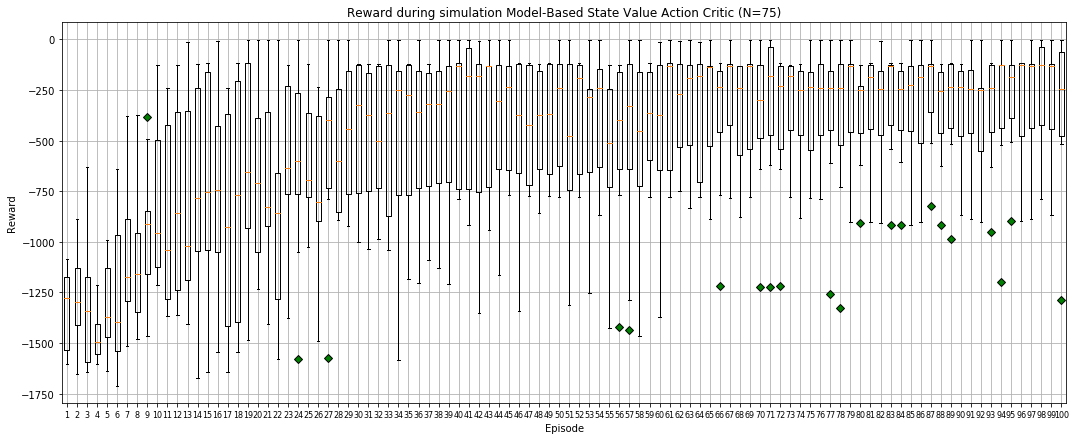

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.boxplot(dict_rewards[75]["rewards"], positions=np.arange(1,101,1), flierprops=green_diamond)
ax.set_title("Reward during simulation Model-Based State Value Action Critic (N=75)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.xticks(fontsize=x_fontsize)
plt.grid()
plt.show()

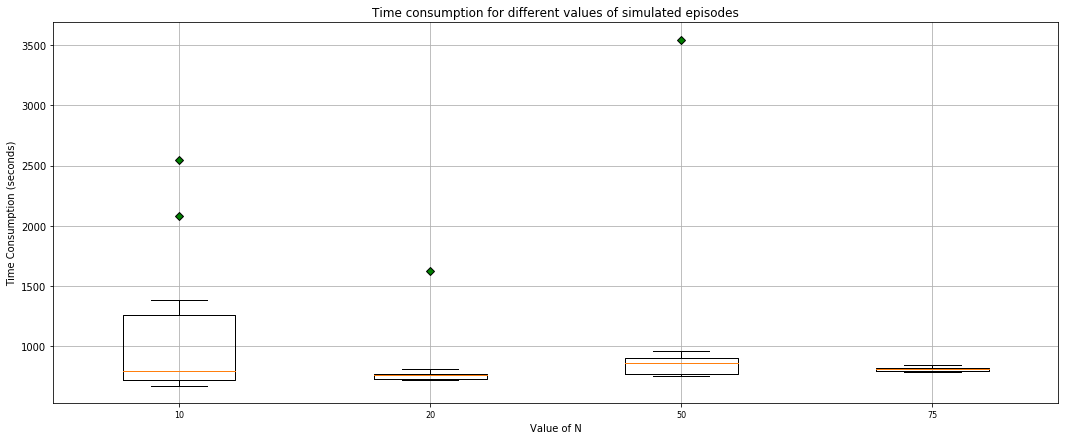

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(18,7)
ax.boxplot([dict_rewards[key]["times"].reshape(10) for key in dict_rewards.keys()], 
           labels=[10, 20, 50, 75],
           flierprops=green_diamond)
ax.set_title("Time consumption for different values of simulated episodes")
plt.xlabel("Value of N")
plt.ylabel("Time Consumption (seconds)")
plt.xticks(fontsize=x_fontsize)
plt.grid()
plt.show()

The increase of the value of $N$ resulted in an increase in the variation of the reward values. Using too many simulation episodes insert the noise the model contain in the agent, however, fewer simulation episodes doesn't affect badly the agent, as can be seen by the first boxplot.  Regarding the time consumption, there is no significant change between the different values of $N$, the results were also influenced by the other tasks that were runnning in the computer in parallel, however the predictions of the model doesn't represent a significant impact in terms of time conusmption, since it's not as time consuming as the training or fitting of the model.  

### Exercise 2.5.

Compare the performance of your model-based state-value actor- critic to DDPG from the previous exercise. Discuss how they are related. What is the advantage of using a model over a replay memory? And disadvantage? Why can SVAC not use experience replay?

#### Answer:

The results found for DDPG in the last exercise were:

  | Model | Metric | Mean Value | Median Value | Standard Deviation |
   |---|---|---|---|---|
   |DDPG| Rise Time |  36.34| 30.00| 12.657|
  |DDPG| Computation Time (s)| 530.209 | 479.3324 | 117.308|


   
The rise time found here with model-based state value action critic is better than the one for DDPG. Regarding the time consumption, the values are similar for both approaches. One of the main advantages is that model-based SVAC only trains the model at the end of each real episode, reducing computational cost, however SVAC is trained with the data from the memory. Other advantage, is that the update on $w$ and $\theta$ are enabled in every single step of the real episode, while in the DDPG, is necessary for the memory to achieve a minimal size, losing a few time-steps were no update in the model is actually done. And also, tith a model is possible to search pairs of state and action that weren't necessarily explore by the agent in the real world, however it would be susceptible to noise and error. For SVAC there is no need for experience replay because while DDPG is trained with a batch memory, SVAC uses the temporal difference error $\delta$ to compute the policy gradient, enabling the model to update the policy at each time-step, and the memory is only used in the model-based to actually train the model of the environment.